# MVP in Altair

So, in the explore.ipynb I identified some initial observations for a 'minimum viable project,' but the 
graphs are made with the pandas built-ins. These are great for an analyst to get a quick look at data, but
for business slides you're going to want something more consistent, nice axis labels, and so on. 

I decided to try Altair for this. 

In [1]:
import pandas as pd
import numpy as np
import altair as alt

from pathlib import Path

In [2]:
%load_ext watermark
%watermark -iv

pandas 0.24.2
numpy  1.16.4
altair 3.1.0



In [3]:
# Data load
data = Path('../data/churn_cleaned.pkl')
assert(data.exists())
df = pd.read_pickle(data)
df.shape

(7043, 21)

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

# Overview - who churned?

In [5]:
df['cust_type'] = ''
df.loc[(df.PhoneService == 'Yes') & (df.InternetService == 'No'), 'cust_type'] = 'Phone'
df.loc[(df.PhoneService == 'No') & (df.InternetService != 'No'), 'cust_type'] = 'Internet'
df.loc[df.cust_type == '', 'cust_type'] = 'Both'
chart_data = df.groupby(['cust_type','Churn'])['customerID'].count().reset_index()

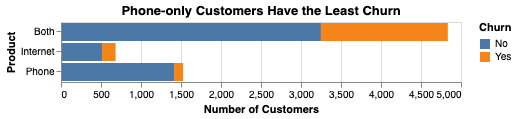

In [6]:
alt.Chart(chart_data,
                title='Phone-only Customers Have the Least Churn'
         ).mark_bar(
         ).encode(
                alt.X('sum(customerID)', title='Number of Customers'),
                alt.Y('cust_type', title='Product'),
                color='Churn',
                order=alt.Order(
                    'Churn',
                    sort='ascending'
                )
         )

# Internet Churn by Product

In [7]:
chart_data = df.groupby(["InternetService","Churn"])['customerID'].count().reset_index()
chart_data = chart_data.query('InternetService != "No"')

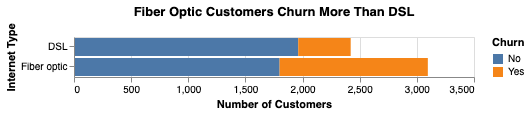

In [8]:
alt.Chart(chart_data,
         title='Fiber Optic Customers Churn More Than DSL'
         ).mark_bar(
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('InternetService', title='Internet Type'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

# Churn by Monthly Charges

This may be an indication that our product is not perceived as a good value, but it may also be
because our churning customers use the more expensive fiber optic service.

In [9]:
df['MonthlyChargeBin'] = pd.cut(df.MonthlyCharges, bins=5).astype(str)
chart_data = df.groupby(['MonthlyChargeBin','Churn'])['customerID'].count().reset_index()

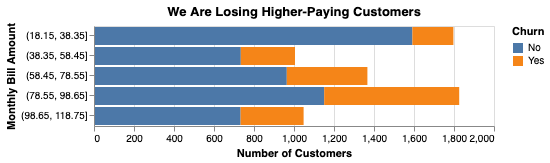

In [10]:
alt.Chart(chart_data,
         title='We Are Losing Higher-Paying Customers',
         ).mark_bar(
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('MonthlyChargeBin',title='Monthly Bill Amount'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

# New Customer Churn

In [11]:
df['NewCustomer'] = df.tenure <= 11

In [12]:
chart_data = df.groupby(['NewCustomer','Churn'])['customerID'].count().reset_index()
chart_data.NewCustomer = chart_data.NewCustomer.map({True:'Less than One Year',False:'One Year+'})

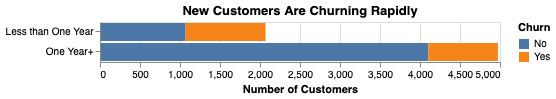

In [13]:
alt.Chart(chart_data,
         title='New Customers Are Churning Rapidly'
         ).mark_bar(
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('NewCustomer', title=None),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

In [14]:
chart_data = df.query('tenure <= 12 and tenure > 0').groupby(['tenure','Churn'])['customerID'].count().reset_index()

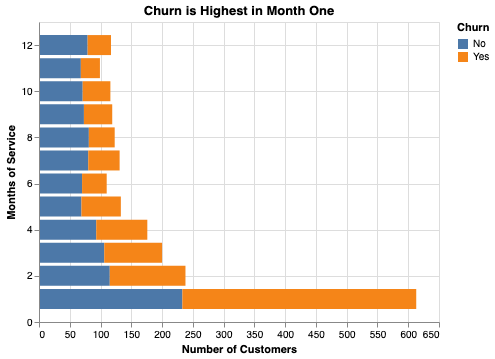

In [15]:
alt.Chart(chart_data,
         title='Churn is Highest in Month One'
         ).mark_bar(
                size=20,
                dy=5
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('tenure', title='Months of Service', sort='ascending'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )

# Payment Method

In [16]:
chart_data = df.groupby(['PaymentMethod', 'Churn'])['customerID'].count().reset_index()
chart_data

,PaymentMethod,Churn,customerID
0,Bank transfer (automatic),No,1286
1,Bank transfer (automatic),Yes,258
2,Credit card (automatic),No,1290
3,Credit card (automatic),Yes,232
4,Electronic check,No,1294
5,Electronic check,Yes,1071
6,Mailed check,No,1304
7,Mailed check,Yes,308


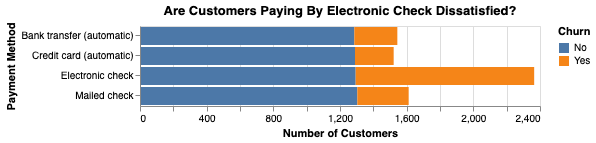

In [17]:
alt.Chart(chart_data,
         title='Are Customers Paying By Electronic Check Dissatisfied?'
         ).mark_bar(
         ).encode(
            alt.X('sum(customerID)', title='Number of Customers'),
            alt.Y('PaymentMethod:N', title='Payment Method'),
            color='Churn',
            order=alt.Order(
                'Churn',
                sort='ascending'
            )
         )